In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_12_months = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_12_months)

('2017-08-23',)


In [11]:
# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(year_ago)

2016-08-23


In [12]:
# Perform a query to retrieve the data and precipitation scores
prcp_data_scores = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > year_ago).\
    order_by(Measurement.date).all()

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_data_scores_df = pd.DataFrame(prcp_data_scores)
prcp_data_scores_df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


In [14]:
# Sort the dataframe by date
prcp_data_scores_df.set_index('date').head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


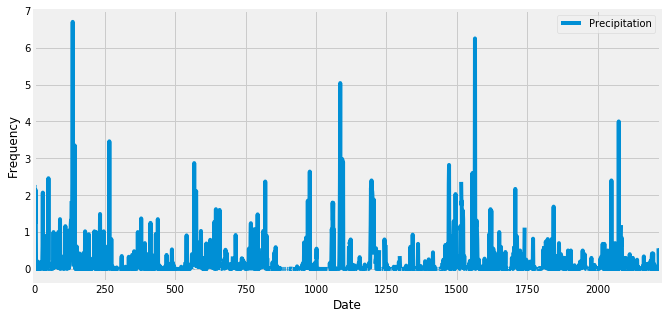

In [50]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = prcp_data_scores_df.plot(figsize=(10,5))
ax.set_ylabel("Frequency")
ax.set_xlabel("Date")
plt.legend(["Precipitation"])
plt.show()

![precipitation](Images/precipitation.png)

In [29]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_data_scores_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [30]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station).count()
print(f"Station Count: {station_count}")

Station Count: 9


In [31]:
# How many stations are available in this dataset?
print(f"Station Count: {station_count}")

Station Count: 9


In [32]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [49]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

station_id = active_stations[0][0]

lowest_temp = (session.query(Measurement.tobs)
                    .filter(Measurement.station == station_id)
                    .order_by(Measurement.tobs.asc())
                    .first())
lowest_temp = lowest_temp[0]

highest_temp = (session.query(Measurement.tobs)
                    .filter(Measurement.station == station_id)
                    .order_by(Measurement.tobs.desc())
                    .first())
highest_temp = highest_temp[0]

average_temp = (session.query(func.avg(Measurement.tobs))
                  .filter(Measurement.station == station_id))
average_temp = "{0:.3}".format(average_temp[0][0])



print(f" The most active station =  {station_id}")
print(f" The lowest temperature recorded = {lowest_temp}")
print(f" The highest temperature recorded = {highest_temp}")
print(f" The average temperature recorded = {average_temp}")

 The most active station =  USC00519281
 The lowest temperature recorded = 54.0
 The highest temperature recorded = 85.0
 The average temperature recorded = 71.7


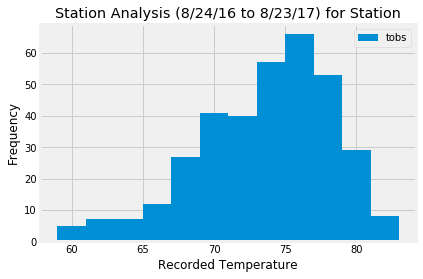

In [54]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_observations = session.query(Measurement.tobs).\
                                filter(Measurement.station == station_id).\
                                filter(Measurement.date >= year_ago).\
                                order_by(Measurement.date.desc()).all()
temp_observations_df = pd.DataFrame(temp_observations)

plt.hist(temp_observations_df['tobs'], bins=12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Frequency")
plt.title("Station Analysis (8/24/16 to 8/23/17) for Station")
plt.legend(["tobs"])
plt.show()

![precipitation](Images/station-histogram.png)

In [55]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [56]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip = '2019-04-08 to \n 2019-04-19'
trip_start_date = '2017-04-08'
trip_end_date = '2017-04-19'
 
trip_temp = calc_temps(trip_start_date, trip_end_date)

trip_temp

[(67.0, 73.6, 83.0)]

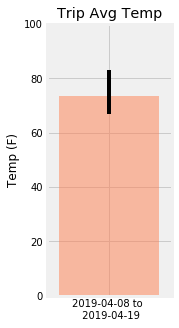

In [128]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

min_trip_temp = trip_temp[0][0]
average_trip_temp = trip_temp[0][1]
max_trip_temp = trip_temp[0][2]

min_error = average_trip_temp - min_trip_temp
max_error = max_trip_temp - average_trip_temp

error_bars = np.array([[min_error], [max_error]])

plt.figure(figsize=(2,5))
plt.bar(trip, average_trip_temp, yerr = error_bars, color = "coral", alpha = .5)
plt.ylim(0, 100)
plt.xlim(-0.5, 0.5)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.grid(.3)

In [133]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
station_data_list = ([
        Station.station, 
        Station.name, 
        func.sum(Measurement.prcp), 
        Station.latitude, 
        Station.longitude, 
        Station.elevation
])

rain_data = (session.query(*sel)
                   .filter(Station.station == Measurement.station)
                   .filter(Measurement.date >= trip_start_date)
                   .filter(Measurement.date <= trip_end_date)
                   .group_by(Station.station)
                   .order_by(func.sum(Measurement.prcp).desc())
                   .all())
print(rain_data)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 7.38, 21.3331, -157.8025, 152.4), ('USC00519281', 'WAIHEE 837.5, HI US', 6.979999999999999, 21.45167, -157.84888999999998, 32.9), ('USC00513117', 'KANEOHE 838.1, HI US', 2.48, 21.4234, -157.8015, 14.6), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 0.86, 21.5213, -157.8374, 7.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 0.8099999999999999, 21.33556, -157.71139, 19.5), ('USC00519397', 'WAIKIKI 717.2, HI US', 0.31000000000000005, 21.2716, -157.8168, 3.0), ('USC00517948', 'PEARL CITY, HI US', 0.0, 21.3934, -157.9751, 11.9)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


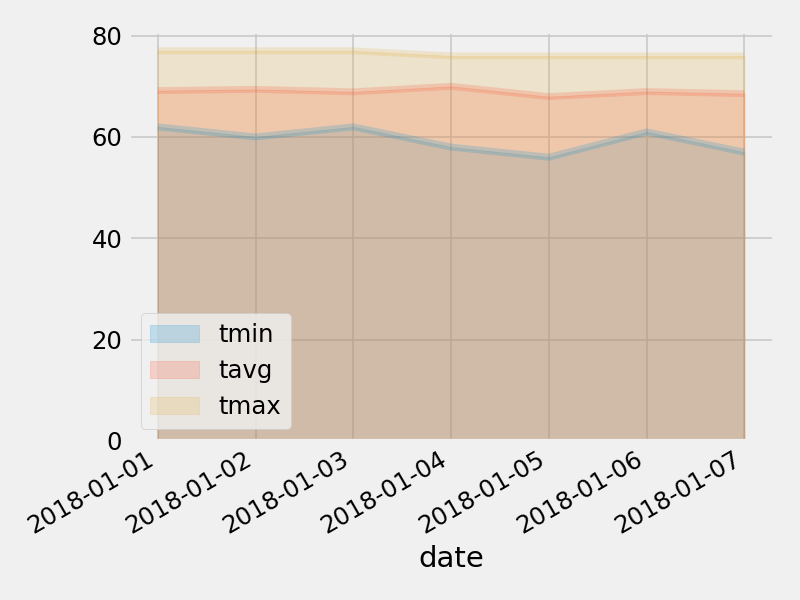

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
